##### Assignment 2: Designing AI Solutions: Rapid Prototyping with and without Generative AI Tools

##### Importing the required libraries 

##### These are the required Python libraries for data analysis, visualization, and model building.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


##### Loding the Dataset

##### Load the Operating Room Utilization dataset and inspect its structure and columns.

In [2]:
file_path = "data/2022_Q1_OR_Utilization.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

print("Dataset Loaded Successfully")
print(df.head())
print("\nColumns:", df.columns.tolist())


Dataset Loaded Successfully
   index  Encounter ID      Date  OR Suite      Service  CPT Code  \
0      0         10001  01/03/22         1     Podiatry     28110   
1      1         10002  01/03/22         1     Podiatry     28055   
2      2         10003  01/03/22         1     Podiatry     28297   
3      3         10004  01/03/22         1     Podiatry     28296   
4      4         10005  01/03/22         2  Orthopedics     27445   

                             CPT Description  Booked Time (min)  \
0   Partial ostectomy, fifth metatarsal head                 90   
1  Neurectomy, intrinsic musculature of foot                 60   
2                       Lapidus bunionectomy                150   
3         Bunionectomy with distal osteotomy                120   
4        Arthroplasty, knee, hinge prothesis                120   

         OR Schedule          Wheels In         Start Time           End Time  \
0  01/03/22 07:00 AM  01/03/22 07:05 AM  01/03/22 07:32 AM  01/03/22 09:0

##### Data Preprocessing

###### Clean and prepare the dataset:

###### Convert time columns to datetime

###### Create duration-based features

###### Extract useful time info (like start hour, day of week)

###### Remove missing and invalid records

In [3]:
time_cols = ['Start Time', 'End Time', 'Wheels In', 'Wheels Out']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['Actual OR Duration (min)'] = (df['End Time'] - df['Start Time']).dt.total_seconds() / 60
df['Setup Duration (min)'] = (df['Start Time'] - df['Wheels In']).dt.total_seconds() / 60
df['Room Occupancy (min)'] = (df['Wheels Out'] - df['Wheels In']).dt.total_seconds() / 60
df['Start Hour'] = df['Start Time'].dt.hour
df['Day of Week'] = df['Start Time'].dt.day_name()

df = df.dropna(subset=['Actual OR Duration (min)', 'Booked Time (min)', 'Service', 'CPT Description', 'OR Suite'])
df = df[df['Actual OR Duration (min)'] > 0]

print("\n Data Preprocessed Successfully")
print(df[['Service', 'Booked Time (min)', 'Actual OR Duration (min)']].head())


C:\Users\User\AppData\Local\Temp\ipykernel_23412\3094064281.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_23412\3094064281.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_23412\3094064281.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_23412\3094064281.py:3: UserWarning: Could not in


 Data Preprocessed Successfully
       Service  Booked Time (min)  Actual OR Duration (min)
0     Podiatry                 90                      93.0
1     Podiatry                 60                      48.0
2     Podiatry                150                      22.0
3     Podiatry                120                      57.0
4  Orthopedics                120                     108.0


##### Feature Selection

##### Select input features (X) and the target variable (y) for model training.

In [4]:
features = ['Service', 'CPT Description', 'Booked Time (min)', 'OR Suite', 'Start Hour', 'Day of Week']
target = 'Actual OR Duration (min)'

X = df[features]
y = df[target]


#### Categorical Encoding

##### Prepare categorical and numerical features for machine learning using OneHotEncoder.

In [5]:
categorical_features = ['Service', 'CPT Description', 'Day of Week']
numerical_features = ['Booked Time (min)', 'OR Suite', 'Start Hour']

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)


##### Train-Test Split

##### Split the data into training (80%) and testing (20%) sets for model evaluation.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\n📊 Training Samples:", len(X_train), " | Testing Samples:", len(X_test))



📊 Training Samples: 1737  | Testing Samples: 435


##### Model Training

##### Train two models:

##### Linear Regression — for a simple baseline

##### Random Forest Regressor — for better performance

In [7]:
## (a) Linear Regression (Baseline)
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

## (b) Random Forest Regressor (Optimized)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)


##### Evaluation

##### Evaluating both models using Mean Absolute Error (MAE) and R² Score to check prediction accuracy.

In [8]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → MAE: {mae:.2f} min | R²: {r2:.2f}")
    return mae, r2

print("\n📈 Model Performance:")
mae_lr, r2_lr = evaluate_model(y_test, lr_pred, "Linear Regression")
mae_rf, r2_rf = evaluate_model(y_test, rf_pred, "Random Forest Regressor")



📈 Model Performance:
Linear Regression → MAE: 3.82 min | R²: 0.95
Random Forest Regressor → MAE: 0.05 min | R²: 1.00


##### Visualization

##### Visualize model performance with:

##### Predicted vs Actual durations

##### Residual (error) distribution

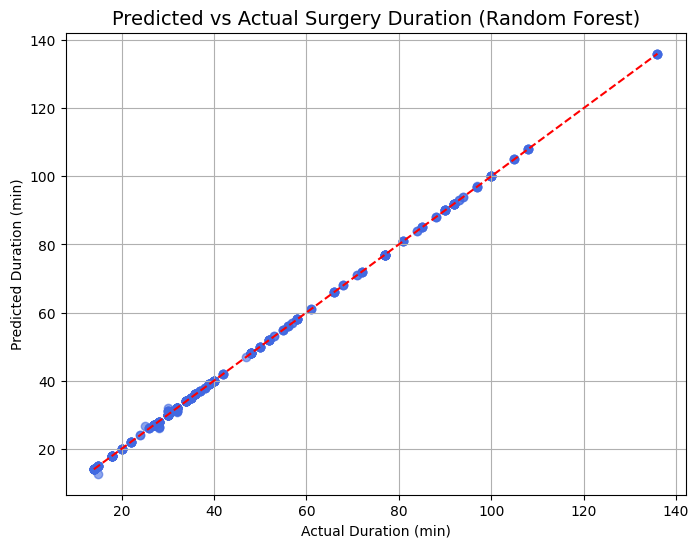

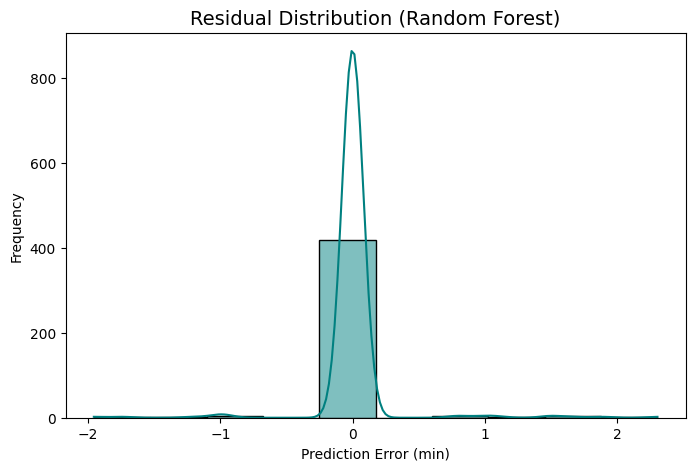

In [9]:
## Predicted vs Actual (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Surgery Duration (Random Forest)', fontsize=14)
plt.xlabel('Actual Duration (min)')
plt.ylabel('Predicted Duration (min)')
plt.grid(True)
plt.show()

## Residual Distribution
residuals = y_test - rf_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='teal')
plt.title('Residual Distribution (Random Forest)', fontsize=14)
plt.xlabel('Prediction Error (min)')
plt.ylabel('Frequency')
plt.show()
